In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torch.utils.data.dataset import Dataset

from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

import pandas as pd
import numpy as np

from PIL import Image as I
from IPython.display import Image
from IPython.core.display import Image, display

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
batch_size = 1
m = 60

In [38]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, csv_path, transform):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        
        self.transform = transform

        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)

        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        single_image_name = "data-nodules2d/imgs/" + single_image_name + ".png"
        
        # Open image
        img_as_img = I.open(single_image_name)

        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len


In [42]:
dataset = CustomDatasetFromImages(csv_path="./2dlabels.csv", transform = transforms.Compose([transforms.ToTensor()]))

In [43]:
# dataset = datasets.ImageFolder(root='./data-nodules2d', transform = transforms.Compose([transforms.ToTensor()]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.image_arr), len(dataloader)

(39274, 39274)

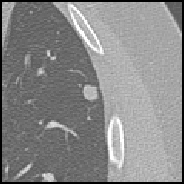

In [57]:
fixed_x, label = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

In [154]:
x = fixed_x[0][0]
x.shape

torch.Size([180, 180])

In [202]:
class Net(nn.Module):
    def __init__(self, m):
        super(Net, self).__init__()
        self.m = m
        mby4 = m//4
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1,padding = 1)
        self.fc1 = nn.Linear(64 * mby4 * mby4, 64)
        self.regression = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64*mby4*mby4)
        self.convTrans1 = nn.ConvTranspose2d(64,32,3,1)
        self.conv3 = nn.Conv2d(64,32,3,1,padding = 1)
        self.conv4 = nn.Conv2d(32,1,3,1,padding = 1)
        self.convTrans2 = nn.ConvTranspose2d(32,1,3,1)
    
    def tiling(self, x):
        m = self.m
        d = 180//m
        x = x[0, 0]
        tiled = x.unfold(0,m,m).unfold(1,m,m)
        tiled = tiled.reshape(d*d, 1, m, m)
        return tiled
    
    def untiling(self, x):
        m = self.m
        d = 180//m
        merge = [0]*d
        for i in range(d):
            row = []
            for j in range(d):
                row.append(x[d*i+j])
            
            merge[i] = torch.cat(row, dim=1)
                
#         merge[i] = torch.cat([x[d*i],x[1],x[2]],dim = 1)
#         b = torch.cat([x[3],x[4],x[5]],dim = 1)
#         c = torch.cat([x[6],x[7],x[8]],dim = 1)
        
        x = torch.cat(merge, dim=2)
        return x
    
#     def upsample1(self, x):
#         x = self.fc2(x)
#         x = x.reshape(9,-1,56,56)
#         x = self.convTrans1(x)
#         x = F.relu(x)
#         x = self.convTrans2(x)
#         return x
    
    def upsample(self, x):
        m = self.m
        d = 180//m
        x = self.fc2(x)
        x = x.reshape(d*d,-1,m//4,m//4)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv3(x)
        x = F.relu(x)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv4(x)
        x = torch.sigmoid(x)
        return x

    def downsample(self, x):
        d = 180//m
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.reshape(d*d,-1)
        x = self.fc1(x)
        
        return x
    
    def forward(self, x):
        x = self.tiling(x)
        x = self.downsample(x)
        self.Vreconst = x
        I_reconst = self.untiling(self.upsample(x))
        
        Vprime = []
        for i in range(len(x)):
            Vnot_i = self.pool(x, i)
            vprime_i = self.regression(Vnot_i)
            Vprime.append(vprime_i)
        Vprime = torch.cat(Vprime, dim = 0)
        self.Vprime = Vprime
        I_prime = self.untiling(self.upsample(Vprime))
        return I_prime, I_reconst
    
    def pool(self, x, i):
        x = torch.cat((x[0:i], x[i+1:]))
        x = x.mean(0)
        x = x.reshape(1,-1)
        return x

In [203]:
m = 4
model = Net(m)
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [204]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (regression): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (convTrans1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convTrans2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [205]:
def train(train_loader):
    epochs = 5
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
#             data = fixed_x
            I_prime,I_reconst = model(data)
            data = data[:, 0]
#             print(data.shape,I_prime.shape,I_reconst.shape)
            l1 = loss(data, I_prime)
            l2 = loss(data, I_reconst)
            (l1+l2).backward()
            optimizer.step()

            if batch_idx % 2 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), l1.item(),l2.item()))

train(dataloader)


/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 0 [0/39274 (0%)]	Loss: 0.020501 0.020533
Train Epoch: 0 [2/39274 (0%)]	Loss: 0.029482 0.028919
Train Epoch: 0 [4/39274 (0%)]	Loss: 0.024871 0.023688
Train Epoch: 0 [6/39274 (0%)]	Loss: 0.022371 0.021106
Train Epoch: 0 [8/39274 (0%)]	Loss: 0.025872 0.026018
Train Epoch: 0 [10/39274 (0%)]	Loss: 0.020513 0.020714
Train Epoch: 0 [12/39274 (0%)]	Loss: 0.018046 0.017991
Train Epoch: 0 [14/39274 (0%)]	Loss: 0.024849 0.024640
Train Epoch: 0 [16/39274 (0%)]	Loss: 0.020383 0.017919
Train Epoch: 0 [18/39274 (0%)]	Loss: 0.045876 0.043442
Train Epoch: 0 [20/39274 (0%)]	Loss: 0.024915 0.025102
Train Epoch: 0 [22/39274 (0%)]	Loss: 0.023581 0.023318
Train Epoch: 0 [24/39274 (0%)]	Loss: 0.018984 0.018851
Train Epoch: 0 [26/39274 (0%)]	Loss: 0.016825 0.016896
Train Epoch: 0 [28/39274 (0%)]	Loss: 0.021958 0.021862
Train Epoch: 0 [30/39274 (0%)]	Loss: 0.016162 0.016292
Train Epoch: 0 [32/39274 (0%)]	Loss: 0.021919 0.021642
Train Epoch: 0 [34/39274 (0%)]	Loss: 0.022536 0.022123
Train Epoch: 0 

Train Epoch: 0 [296/39274 (1%)]	Loss: 0.015309 0.013591
Train Epoch: 0 [298/39274 (1%)]	Loss: 0.025624 0.022996
Train Epoch: 0 [300/39274 (1%)]	Loss: 0.019071 0.018731
Train Epoch: 0 [302/39274 (1%)]	Loss: 0.019191 0.018930
Train Epoch: 0 [304/39274 (1%)]	Loss: 0.017695 0.020710
Train Epoch: 0 [306/39274 (1%)]	Loss: 0.026310 0.035242
Train Epoch: 0 [308/39274 (1%)]	Loss: 0.019640 0.023747
Train Epoch: 0 [310/39274 (1%)]	Loss: 0.019356 0.016252
Train Epoch: 0 [312/39274 (1%)]	Loss: 0.023511 0.025285
Train Epoch: 0 [314/39274 (1%)]	Loss: 0.019509 0.015872
Train Epoch: 0 [316/39274 (1%)]	Loss: 0.012002 0.015557
Train Epoch: 0 [318/39274 (1%)]	Loss: 0.017116 0.018015
Train Epoch: 0 [320/39274 (1%)]	Loss: 0.026096 0.029981
Train Epoch: 0 [322/39274 (1%)]	Loss: 0.014703 0.011844
Train Epoch: 0 [324/39274 (1%)]	Loss: 0.015167 0.013897
Train Epoch: 0 [326/39274 (1%)]	Loss: 0.015437 0.017989
Train Epoch: 0 [328/39274 (1%)]	Loss: 0.022765 0.018557
Train Epoch: 0 [330/39274 (1%)]	Loss: 0.025548 0

Train Epoch: 0 [590/39274 (2%)]	Loss: 0.017143 0.020036
Train Epoch: 0 [592/39274 (2%)]	Loss: 0.025885 0.021326
Train Epoch: 0 [594/39274 (2%)]	Loss: 0.022529 0.022573
Train Epoch: 0 [596/39274 (2%)]	Loss: 0.018939 0.028097
Train Epoch: 0 [598/39274 (2%)]	Loss: 0.020891 0.026429
Train Epoch: 0 [600/39274 (2%)]	Loss: 0.026027 0.027345
Train Epoch: 0 [602/39274 (2%)]	Loss: 0.015809 0.017824
Train Epoch: 0 [604/39274 (2%)]	Loss: 0.013607 0.017786
Train Epoch: 0 [606/39274 (2%)]	Loss: 0.023138 0.031634
Train Epoch: 0 [608/39274 (2%)]	Loss: 0.018966 0.013147
Train Epoch: 0 [610/39274 (2%)]	Loss: 0.018090 0.022829
Train Epoch: 0 [612/39274 (2%)]	Loss: 0.018088 0.020351
Train Epoch: 0 [614/39274 (2%)]	Loss: 0.017617 0.018242
Train Epoch: 0 [616/39274 (2%)]	Loss: 0.012506 0.020135
Train Epoch: 0 [618/39274 (2%)]	Loss: 0.019181 0.018967
Train Epoch: 0 [620/39274 (2%)]	Loss: 0.018169 0.021713
Train Epoch: 0 [622/39274 (2%)]	Loss: 0.023823 0.028544
Train Epoch: 0 [624/39274 (2%)]	Loss: 0.025415 0

Train Epoch: 0 [884/39274 (2%)]	Loss: 0.015845 0.014462
Train Epoch: 0 [886/39274 (2%)]	Loss: 0.028158 0.029661
Train Epoch: 0 [888/39274 (2%)]	Loss: 0.016440 0.021169
Train Epoch: 0 [890/39274 (2%)]	Loss: 0.009847 0.011969
Train Epoch: 0 [892/39274 (2%)]	Loss: 0.025718 0.033222
Train Epoch: 0 [894/39274 (2%)]	Loss: 0.022602 0.027364
Train Epoch: 0 [896/39274 (2%)]	Loss: 0.015512 0.016540
Train Epoch: 0 [898/39274 (2%)]	Loss: 0.015419 0.019255
Train Epoch: 0 [900/39274 (2%)]	Loss: 0.012154 0.013564
Train Epoch: 0 [902/39274 (2%)]	Loss: 0.016060 0.021839
Train Epoch: 0 [904/39274 (2%)]	Loss: 0.025567 0.024996
Train Epoch: 0 [906/39274 (2%)]	Loss: 0.023898 0.022386
Train Epoch: 0 [908/39274 (2%)]	Loss: 0.020522 0.020620
Train Epoch: 0 [910/39274 (2%)]	Loss: 0.021905 0.019294
Train Epoch: 0 [912/39274 (2%)]	Loss: 0.018969 0.023643
Train Epoch: 0 [914/39274 (2%)]	Loss: 0.020433 0.021862
Train Epoch: 0 [916/39274 (2%)]	Loss: 0.018876 0.021666
Train Epoch: 0 [918/39274 (2%)]	Loss: 0.015353 0

Train Epoch: 0 [1174/39274 (3%)]	Loss: 0.017767 0.020448
Train Epoch: 0 [1176/39274 (3%)]	Loss: 0.015225 0.016609
Train Epoch: 0 [1178/39274 (3%)]	Loss: 0.016060 0.013891


KeyboardInterrupt: 

In [206]:
Ipr,Ire = model(fixed_x)
Ire.shape

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 180, 180])

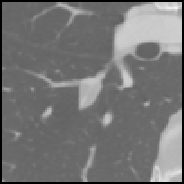

In [207]:
save_image(fixed_x, 'real_image.png')
Image('real_image.png')

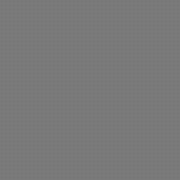

In [208]:
save_image(Ipr, 'real_image.png')
Image('real_image.png')

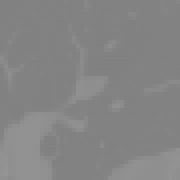

In [209]:
save_image(Ire, 'real_image.png')
Image('real_image.png')

### Compute ROI

In [148]:
torch.matmul(model.Vprime, model.Vreconst.T).long()

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
class Evaluate(nn.Module):
    def __init__(self):
        super(Evaluate, self).__init__()
        self.fc1 = nn.Linear(128, 2)
    
    def forward(self,vector):
        x = self.fc1(vector)
        return x